# 0.0 Imports

In [12]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import warnings
import re


import umap.umap_ as umap

from IPython.display import HTML, Image
from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport

from sklearn            import cluster       as c
from sklearn            import metrics       as m
from sklearn            import preprocessing as pp
from sklearn            import decomposition as dd
from sklearn.manifold   import TSNE
from sklearn            import manifold      as mn
from sklearn            import ensemble      as en
from sklearn            import mixture       as mx

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

warnings.simplefilter("ignore")

## 0.2 Load DataSet

In [18]:
path_s3 = 's3://insiders-dataset-kaka/'

# load data
df_raw = pd.read_csv( 's3://insiders-dataset-kaka/Ecommerce.csv', encoding='unicode_escape' )

# 1.0 Descrição dos Dados

In [20]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data dimensions

In [6]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3 Data Types

In [7]:
 df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [10]:
 # create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change DTypes

In [12]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], infer_datetime_format=True ).dt.date
# customer id
df1['customer_id'] = df1['customer_id'].astype( 'int64' )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


## 1.7 Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributs

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1 Numerical Attributs Investigating

1. Quantity negativa ( pode ser devolução )

2. Preço unitário igual a zero ( pode ser promoção? )

### 1.7.1 Categorical Attributs

In [15]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


# 2.0 Data Filtering

In [20]:
df2 = df1.copy()

In [21]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0 Feature Engineering

In [22]:
df3 = df2.copy()

## 3.1 Feature Selection

In [23]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [24]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

In [25]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

In [28]:
 # Quantity of products purchased
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

In [31]:
#Frequency Purchase

df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

In [32]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

In [35]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,0.333333


# 4.0 EDA

In [36]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.3 Estudo do Espaço

In [54]:
# selected dataset
cols_selected = ['gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()
df43 = df43[ cols_selected ]

In [55]:
mm = pp.MinMaxScaler() 

df43['gross_revenue']           = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']            = mm.fit_transform( df43[['recency_days']] )
df43['qtde_products']           = mm.fit_transform( df43[['qtde_products']])
df43['frequency']               = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']            = mm.fit_transform( df43[['qtde_returns']])


X = df43.copy()

In [56]:
X.shape

(2968, 5)

In [57]:
X.head()

,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0.019292,0.997319,0.037770,1.000000,0.004438
1,0.011559,0.150134,0.021692,0.001345,0.003883
2,0.024000,0.005362,0.029476,0.002052,0.005547
3,0.003375,0.254692,0.003445,0.000734,0.000000
4,0.003116,0.892761,0.000255,0.003985,0.002441


### 4.3.4. Tree-Based Embedding

In [62]:
 # training dataset
X = df43.drop( columns=['gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

RandomForestRegressor(random_state=42)

In [63]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

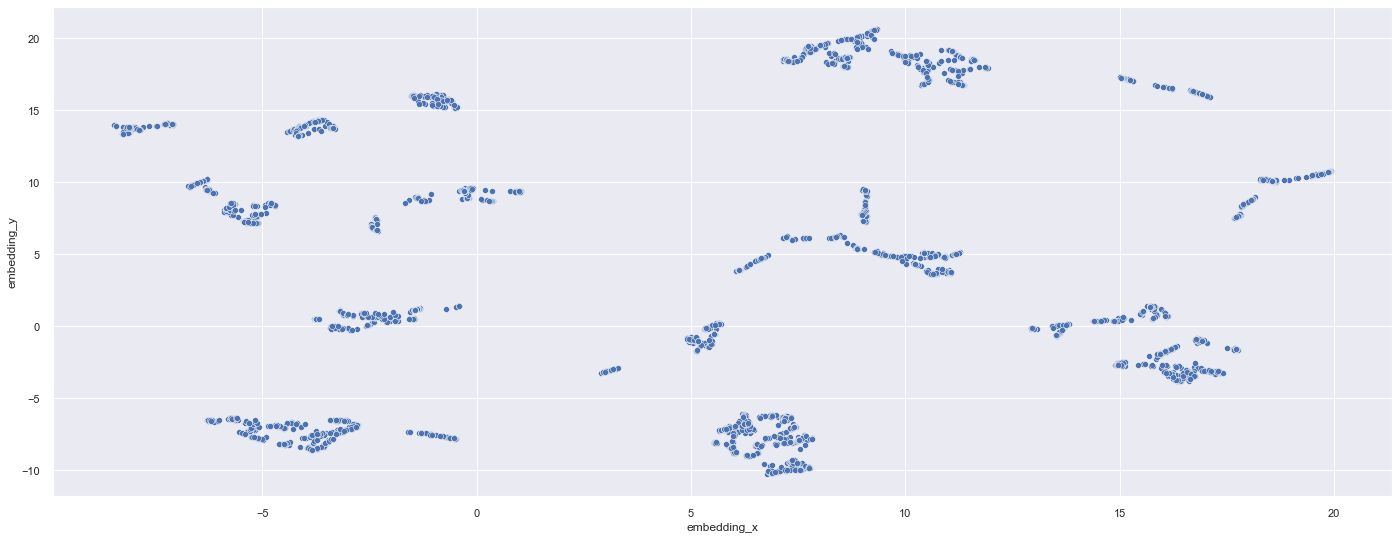

In [64]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# 5.0 Data Preparation

In [67]:
df5 = df_tree.copy()

# 6.0 Feature Selection

In [70]:
df6 = df_tree.copy()

# 7.0 Hyperparameter Fine-Tunning

In [72]:
X = df_tree.copy()

In [73]:
X.head()

,embedding_x,embedding_y
0,10.136566,18.672249
1,18.619751,10.139460
2,11.208997,18.839911
3,-2.429976,0.271937
4,-5.209744,8.388730


In [74]:
#clusters = [2, 3, 4, 5, 6, 7]

In [75]:
clusters = np.arange( 2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## 7.1 K-Means

In [76]:
from sklearn import metrics as m

In [77]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

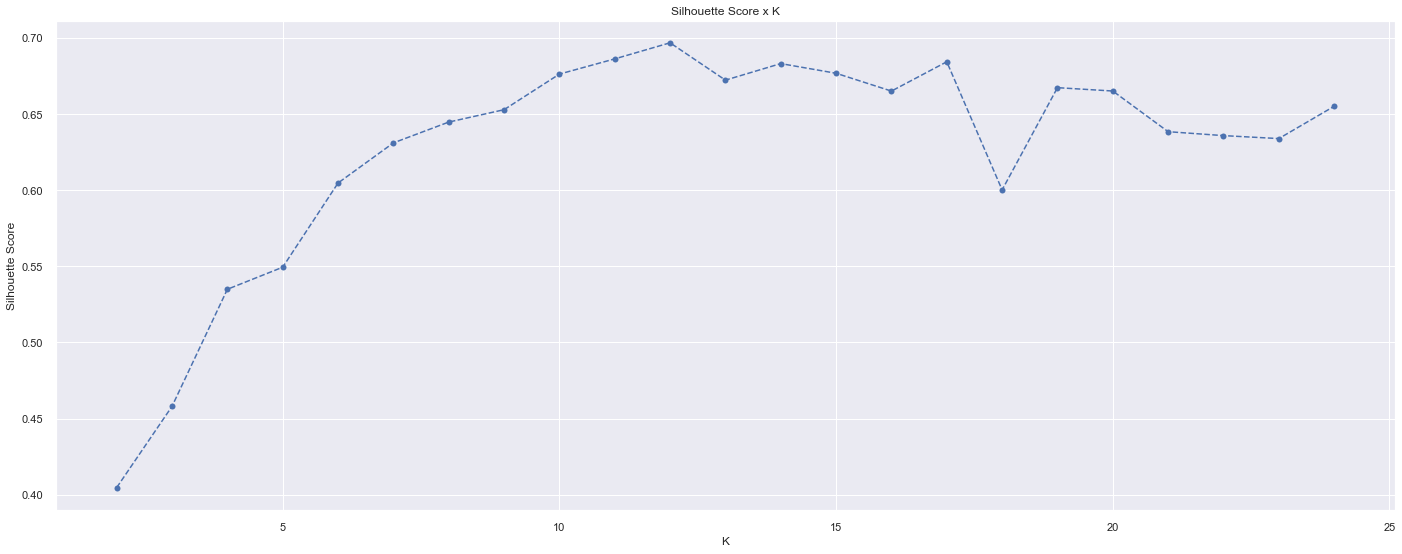

In [78]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2 GMM

In [79]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

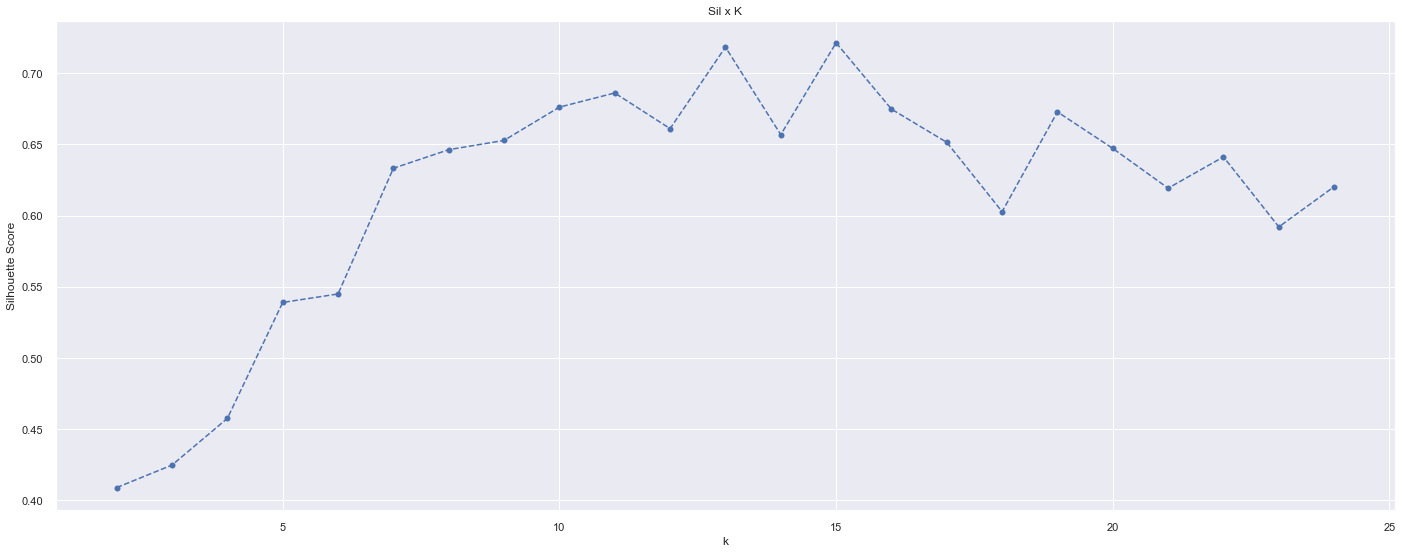

In [80]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.5 Results

In [ ]:
# Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list}
).T

df_results.columns = clusters

In [93]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.404727,0.458060,0.534917,0.549402,0.604678,0.631019,0.644685,0.652816,0.676191,0.686173,0.696737,0.672223,0.683086,0.676729,0.665035,0.684265,0.600152,0.667279,0.665076,0.638377,0.635799,0.633851,0.655046
GMM,0.408953,0.424774,0.457540,0.539011,0.544966,0.633288,0.646334,0.652850,0.676228,0.686173,0.661146,0.718386,0.656886,0.721429,0.674817,0.651489,0.602796,0.672876,0.647226,0.619285,0.641282,0.592093,0.620366
HC,0.380836,0.452735,0.516634,0.527478,0.576391,0.613312,0.656887,0.666879,0.657450,0.670342,0.696737,0.718386,0.693873,0.681525,0.669653,0.684822,0.700526,0.680117,0.652154,0.650017,0.652920,0.649995,0.645402


# 8.0 Model Training

## 8.1 K-Means

In [95]:
# model definition
k = 8

In [97]:
## model definition
gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state=32 )

# model training
gmm_model.fit( X )

# model predict
labels = gmm_model.predict( X )

## 8.2 Cluster Validation

In [98]:
## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.6458191275596619


# 9.0 Cluster Analysis

In [100]:
df9 = X.copy()
df9['cluster'] = labels

In [101]:
df9.head()

,embedding_x,embedding_y,cluster
0,10.136566,18.672249,3
1,18.619751,10.139460,6
2,11.208997,18.839911,3
3,-2.429976,0.271937,7
4,-5.209744,8.388730,1


## 9.1 Visualization Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

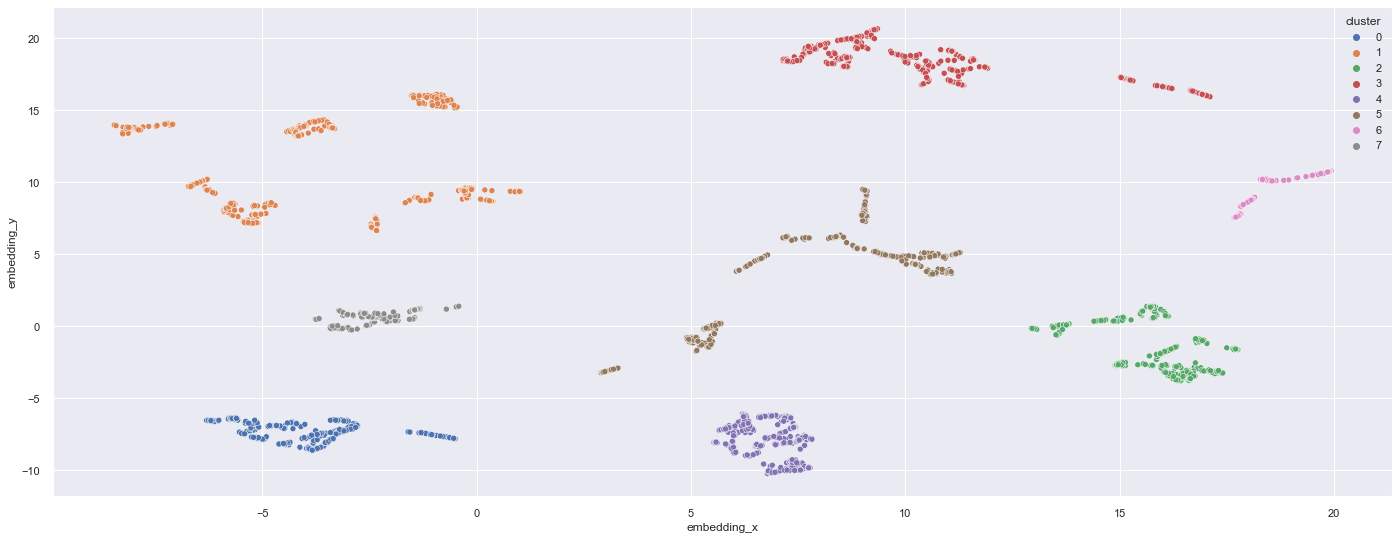

In [102]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

## 9.2 2D Plot

In [104]:
df_viz = df9

## 9.5 Cluster Profile

In [106]:
cols_selected_full = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [107]:
df92 = df4[ cols_selected_full ].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,3
1,13047,3232.59,56.0,171.0,0.028302,35.0,6
2,12583,6705.38,2.0,232.0,0.040323,50.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,7
4,15100,876.00,333.0,3.0,0.073171,22.0,1


In [108]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,322,10.849057,971.025435,75.329193,37.462733,0.074586,6.571429
1,1,592,19.946092,553.770946,114.917230,14.167230,0.291256,6.538851
2,2,404,13.611860,1689.182401,54.801980,89.202970,0.050037,11.542079
3,3,468,15.768194,8836.136389,21.438034,424.134615,0.094571,149.271368
4,4,372,12.533693,1237.753145,61.282258,54.357527,0.043705,8.771505
5,5,490,16.509434,3003.979469,45.953061,120.928571,0.048122,25.244898
6,6,145,4.885445,3164.253379,34.427586,173.875862,0.060415,23.482759
7,7,175,5.896226,827.478286,92.022857,26.822857,0.161952,22.868571


In [109]:
df92['cluster'] = df92['cluster'].map( {3: 'Insiders', 6:'More_Product', 5:'Spend_Money', 2:'Even_More_Products', 4:'Less_Days', 0:'Less_1k', 7:'Critical', 1:'More_Buy'} )

In [110]:
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,Insiders
1,13047,3232.59,56.0,171.0,0.028302,35.0,More_Product
2,12583,6705.38,2.0,232.0,0.040323,50.0,Insiders
3,13748,948.25,95.0,28.0,0.017921,0.0,Critical
4,15100,876.00,333.0,3.0,0.073171,22.0,More_Buy


In [1]:
for i in range(len(df_cluster['customer_id'])):
    print(f""" Cluster {df_cluster['cluster'][i]}:
    -Number of customers: {df_cluster['customer_id'][i]} ({round(df_cluster['perc_customer'][i])}%)
    -Average revenue: ${round(df_cluster['gross_revenue'][i])}
    -Average recency: by each {round(df_cluster['recency_days'][i])} days ({round(df_cluster['recency_days'][i]/7)} week(s))
    -Average unique products purchased: {round(df_cluster['qtde_products'][i])}  
    -Average purchases/month: {round((df_cluster['frequency'][i])*30 ,1)} 
    -Average total products returned: {round(df_cluster['qtde_returns'][i])} """)

NameError: name 'df_cluster' is not defined

Cluster 01
- Número de customers: 255 (13,91% do customers )
- Recência em média: 20.26 dias
- Compras em média: 451 produtos
- Receita em média: $9742.35 dólares

Cluster 02
- Número de customers: 31 (0.71 do customers )
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

Cluster 03
- Número de customers: 4.335 (99% do customers )
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57 dólares

# 10.0 Model to Production

In [112]:
df10 = df92.copy()

In [113]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,Insiders
1,13047,3232.59,56.0,171.0,0.028302,35.0,More_Product
2,12583,6705.38,2.0,232.0,0.040323,50.0,Insiders
3,13748,948.25,95.0,28.0,0.017921,0.0,Critical
4,15100,876.00,333.0,3.0,0.073171,22.0,More_Buy


# 11.0 Deploy to procution

In [ ]:
import sqlite3
from sqlalchemy import create_engine

In [ ]:
df10.dtypes

In [ ]:
df10['recency_days'] = df92['recency_days'].astype( 'int64' )
df10['qtde_products'] = df92['qtde_products'].astype( 'int64' )
df10['qtde_returns'] = df92['qtde_returns'].astype( 'int64' )

In [ ]:
conn = sqlite3.connect( 'insiders_db.sqlite' )
conn.commit()

In [ ]:
#check if table exists on sqlite
check_table = """
    SELECT name FROM sqlite_master WHERE type='table' AND name='insiders';
"""
df_check = pd.read_sql_query(check_table, conn)
#create table if does not exist
if len(df_check) == 0:  #0 = table does not exist, 1 = table exists
    query_create_table_insiders = """
    CREATE TABLE insiders (
        customer_id              INTEGER,
        gross_revenue            REAL,
        recency_days             INTEGER,
        qtde_products            INTEGER,
        frequency                REAL,
        qtde_returns             INTEGER,
        cluster                  INTEGER
    )"""
    conn.execute( query_create_table_insiders )
    print('Table insiders was created!')
else:
    print('Table insiders exists!')

In [ ]:
df10.to_sql('insiders', con=conn, if_exists='append', index=False )

In [ ]:
# consulting database
query = """
    SELECT * FROM insiders 
"""

df = pd.read_sql_query( query, conn )

In [ ]:
df.head()

In [ ]:
conn.close()